# NYC Taxi Dataset COGS 108 Final Project

## Group Members:
Nicholas Martz - A14219345

Guillermo Rios Martinez - A13636152

Angela Zhang - A13063547

Kyle Sung - A13871293

# Introduction and Background

##### Our project’s goal is to predict the time a taxi ride will take given the hour, month, or location of pickup in New York. This is useful for anyone who is interested in taking a taxi ride in New York, whether it be someone who lives there, works there, or simply a tourist looking for a quick ride. This could also be useful for the taxi company, so that they know which times and dates take the longest. This could help the company make changes to the amount of taxis in an area or find alternate routes for a faster time. 

##### We will be using various models to predict the duration of a ride and comparing their results. This includes OLS, linear regression, polynomial regression, random forest, and decision tree. 

# Data Description

### Data given by the NYC Yellow Cab through a Kaggle Dataset (2016)

##### id - unique identifier for each trip
##### vendor_id - a code indicating the provider associated with the trip record
##### pickup_datetime - date ant time when the meter was engaged
##### dropoff_datetime - date and time when the meter was disengaged
##### passenger_count - number of passengers in the vehicle
##### pickup_longitude - longitude where meter was engaged
##### pickup_latitude - latitude where the meter was engaged
##### dropoff_longitude - longitude where the meter was disengaged
##### dropoff_latitude - latitude where the meter was disengaged
##### store_and_fwd_flag - whether the trip was held in vehicle momory before sending to the vendor because the vehicle did not have a connection to the server
##### trip duration - suration of the trip in seconds

# Packages

##### The cell below illustrates all of the libraries we plan on importing to use for our Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import pydot
import io
from scipy import misc
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz

# Cleaning Dataset 

##### We'll first start by cleaning up our dataset. After taking a look at the columns given, we plan on getting rid of variables that aren't needed and one-hot encoding the variables that contain a string for their values. Also, for the sake of runtime, we will only be using 50000 data points. 

##### First, we chose to split the date and time stamp in pickup_datetime to pickup_date and pickup_time. For pickup_time we chose to use just the hour in the timestamp because we assumed that traffic wouldn't change too much within the minutes of the same hour, versus, within hours of the day. For the pickup_date we singled out the month and one-hot encoded it to see if there existed a correlation within time versus date.

##### Secondly, we dropped all unnecessary columns. Id, vendor_id are both unique to each point so there would be no correlation between them and our target. Store_and_fwd_flag just tells us when the data was recorded (on the trip or after) which is irrelevant. And, lastly, we took out dropoff_datetime because this is essentially our trip_duration and pickup_datetime because we already accounted for it. 

In [2]:
dataset = pd.read_csv('train.csv')
dataset = dataset.head(50000)
print("This is the data we started out with.")
dataset.head()

This is the data we started out with.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
#Reformatting the Datetime
dataset['pickup_datetime'] =  pd.to_datetime(dataset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
dataset["pickup_date"] = dataset["pickup_datetime"].dt.month
dataset["pickup_time"] = dataset["pickup_datetime"].dt.hour
dataset = dataset.drop(columns=['id', 'vendor_id', 'store_and_fwd_flag', 'dropoff_datetime', 'pickup_datetime'])
dataset = dataset[['pickup_date', 'pickup_time', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']]

#One Hot Encoding the Months
dataset['Jan'] = np.where(dataset['pickup_date'] == 1, 1, 0)
dataset['Feb'] = np.where(dataset['pickup_date'] == 2, 1, 0)
dataset['Mar'] = np.where(dataset['pickup_date'] == 3, 1, 0)
dataset['Apr'] = np.where(dataset['pickup_date'] == 4, 1, 0)
dataset['May'] = np.where(dataset['pickup_date'] == 5, 1, 0)
dataset['Jun'] = np.where(dataset['pickup_date'] == 6, 1, 0)
dataset = dataset.drop(columns=['pickup_date'])

# Just for format purposes, putting target at the end
dataset['tripDuration'] = dataset['trip_duration']
dataset = dataset.drop(columns=['trip_duration'])

print(dataset.shape)
dataset.head(10)

(50000, 13)


,pickup_time,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Jan,Feb,Mar,Apr,May,Jun,tripDuration
0,17,1,-73.982155,40.767937,-73.964630,40.765602,0,0,1,0,0,0,455
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,0,0,0,0,1,663
2,11,1,-73.979027,40.763939,-74.005333,40.710087,1,0,0,0,0,0,2124
3,19,1,-74.010040,40.719971,-74.012268,40.706718,0,0,0,1,0,0,429
4,13,1,-73.973053,40.793209,-73.972923,40.782520,0,0,1,0,0,0,435
5,22,6,-73.982857,40.742195,-73.992081,40.749184,1,0,0,0,0,0,443
6,22,4,-73.969017,40.757839,-73.957405,40.765896,0,0,0,0,0,1,341
7,7,1,-73.969276,40.797779,-73.922470,40.760559,0,0,0,0,1,0,1551
8,23,1,-73.999481,40.738400,-73.985786,40.732815,0,0,0,0,1,0,255
9,21,1,-73.981049,40.744339,-73.973000,40.789989,0,0,1,0,0,0,1225


In [4]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
print(X.shape)
print(y.shape)

(50000, 12)
(50000,)


# Initial Visualization

##### Below are some initial visualizations we did to illustrate the relationship between one, two, or three variables. 

##### We want to see if we can distinguish a pattern right off the bat. Notice that for the duration portions of the graphs, we can see a pattern where some points lie very high in the duration column. We notice that there lies a cluster of points under 20,000 seconds and another around 80,000 seconds. 80,000 seconds translates to about 22 hours which seems very odd.

##### Our assumption is that this Kaggle dataset didn't correctly take into account travel times which started before midnight (PM) and ended after midnight (AM). It seems that they might have added an extrenous number to the actual travel time due to it being from one day to another. We will omit this later on in the project.

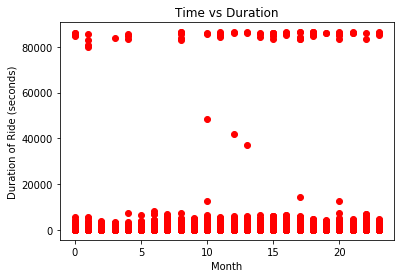

In [5]:
# Time vs Duration
timeAxis = dataset.iloc[:, 0].values
plt.title('Time vs Duration')
plt.xlabel('Month')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(timeAxis, y, color='red')
plt.show()

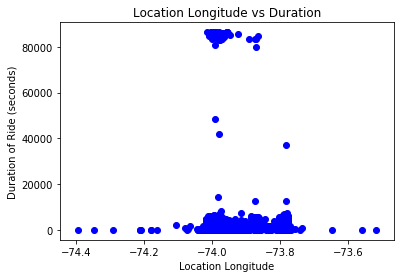

In [6]:
# Time vs Longitude
locationLongAxis = dataset.iloc[:, 2].values
plt.title('Location Longitude vs Duration')
plt.xlabel('Location Longitude')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(locationLongAxis, y, color='blue')
plt.show()

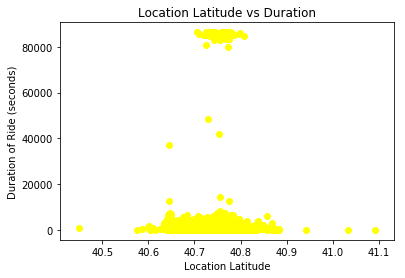

In [7]:
# Time vs Latitude
locationLatAxis = dataset.iloc[:, 3].values
plt.title('Location Latitude vs Duration')
plt.xlabel('Location Latitude')
plt.ylabel('Duration of Ride (seconds)')
plt.scatter(locationLatAxis, y, color='yellow')
plt.show()

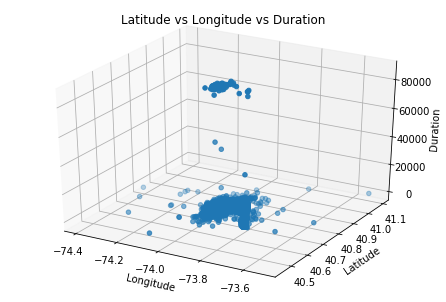

In [8]:
# Latitude vs Longitude vs Duration
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(locationLongAxis, locationLatAxis, y)
ax.set_title('Latitude vs Longitude vs Duration')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Duration')
plt.show()

# Data Analysis and Results

## OLS/Linear Regression

### OLS Original Dataset

##### First, we want to test how the raw dataset with the included outliers (80,000 seconds portion) will be as a linear model. This will give us a baseline and be our comparision to our cleaned up dataset which we will implement later. 

##### We implement a backwards elimination technique to see which predictors we can omit. We come out with a R-squared value of 0.009 which is considered a very bad model for our dataset. Remember, the R-squared value tells us how much the variation in our target variable is explained by the predictor variables. This means that only 0.9% of the variation of our target variables can be explained by the predictors, hence, a bad model to predict the duartion of our trip. 

##### Since our dataset has some false outlier data, we expected our R-Squared value to be low. After running our backwards elimination and OLS summary, we are able to omit pickup time. Intuitively, we can see that this may not be the best idea because pickup time clearly affects the duration of a trip (traffic hour vs non-traffic hour) and we are able to conclude that this dataset is not optimal.

In [9]:
# Building the optimal model using Backwards Elimination
import statsmodels.formula.api as sm

# We have to add a column of 1s because statsmodels.formula.api doesn't account for b0
# To include b0 we can just have x0 = 1, which will tell statsmodel.formula.api to account for b0
# Adding X to an array full of 1s
X_opt = np.append(arr = np.ones((50000, 1)).astype(int), values = X, axis = 1)


# Fit the full model with all possible predictors
# regressor ordinary least squares
regressor_OLS =  sm.OLS(endog = y, exog = X_opt).fit()

print("Using all possible predictors")
print(regressor_OLS.summary())

# Omitting based on 0.5 threshold

# Omit 1st column (pickup time)
X_opt = np.delete(X_opt, 1, axis=1)
regressor_OLS =  sm.OLS(endog = y, exog = X_opt).fit()
print()
print("Omitting pickup time")
print(regressor_OLS.summary())

# Take column of 1s out from optimal model
X_opt = X_opt[:, 1:]
print(X_opt.shape)

Using all possible predictors
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     41.99
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.20e-91
Time:                        23:23:39   Log-Likelihood:            -4.7388e+05
No. Observations:               50000   AIC:                         9.478e+05
Df Residuals:                   49988   BIC:                         9.479e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.441e+05 

### Custom RMSE Function

In [10]:
def custom_validation(random, model, X, y, folds, omit):
    x_error = []
    x_opt_error = []
    
    for i in range(folds):
        # randomize
        random = random.sample(frac=1)
        X = random.iloc[:, :-1].values
        y = random.iloc[:, -1].values
        
        # Size of test
        xRows, xCol = X.shape
        
        # Splitting the dataset into the Training set and Test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/folds, random_state = 0)
    
        # Size of test
        rows, col = X_test.shape
        
        if(model == 'linreg'):
            # Fitting Linear Regression to the Training set
            regressor = LinearRegression()
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        elif(model == 'polyReg') :
            poly = PolynomialFeatures(degree = 3)
            X_poly = poly.fit_transform(X_train)
            poly.fit(X_poly, y_train)
            regressor = LinearRegression()
            regressor.fit(X_poly, y_train)
            y_pred = regressor.predict(poly.fit_transform(X_test))
        elif (model == 'randomForest'):
            # Fitting Random Forest to the Training set
            regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        elif (model == 'decisionTree'):
            regressor = DecisionTreeRegressor(random_state = 0)
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        else:
            print('not linear regression')
        
        x_error.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
        ## Repeating for the most optimal predictors
        
        # Optimal X
        X_opt = np.delete(X, omit, axis=1)
        
        X_opt_train, X_opt_test, y_opt_train, y_opt_test = train_test_split(X_opt, y, test_size = 1/folds, random_state = 0)

        opt_rows, opt_cols = X_opt_test.shape

        if(model == 'linreg'):
            opt_regressor = LinearRegression()
            opt_regressor.fit(X_opt_train, y_opt_train)
            y_pred_opt = opt_regressor.predict(X_opt_test)
        elif(model == 'polyReg') :
            poly_opt = PolynomialFeatures(degree = 3)
            X_poly_opt = poly_opt.fit_transform(X_opt_train)
            poly_opt.fit(X_poly_opt, y_opt_train)
            opt_regressor = LinearRegression()
            opt_regressor.fit(X_poly_opt, y_opt_train)
            y_pred_opt = opt_regressor.predict(poly_opt.fit_transform(X_opt_test))
        elif (model == 'randomForest'):
            opt_regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
            opt_regressor.fit(X_opt_train, y_opt_train)
            y_pred_opt = opt_regressor.predict(X_opt_test)
        elif (model == 'decisionTree'):
            opt_regressor = DecisionTreeRegressor(random_state = 0)
            opt_regressor.fit(X_opt_train, y_opt_train)
            y_pred_opt = opt_regressor.predict(X_opt_test)
        else:
            print('not linear regression')

        x_opt_error.append(np.sqrt(mean_squared_error(y_opt_test, y_pred_opt)))
    
    return np.mean(x_error), np.mean(x_opt_error), regressor

### Linear Model (Original Dataset)

##### This makes a call to the custom_validation function which returns us our RMSE for our model selected, in this case, a Linear Regression model. Our results indicate that our train and test predictors for both categories are pretty bad, predicting about 50 minutes off the duration time. Imagine taking a taxi cab in NYC with an estimated time of 60 minutes when it was actually only 10. You would probably think that this would be a bad predictor and never decide to trust it again. 

##### Remember, we expect a terrible RMSE because this is using the original dataset (our range of values are listed below). Also, note that this is taking into consideration trip that were 1 second which is impossible and the driver must have accidentally started the fare and shut it off immediately.

In [11]:
rmse = custom_validation(dataset, 'linreg', X, y, 10, 0)
print('The Linear Regression RMSE of all predictors', rmse[0])
print('The Linear Regression RMSE of the optimal predictors', rmse[1])
print('Largest value in y:', np.max(y))
print('Smallest value in y:', np.min(y))

The Linear Regression RMSE of all predictors 3295.8391008919716
The Linear Regression RMSE of the optimal predictors 3295.8743610931588
Largest value in y: 86357
Smallest value in y: 1


### More Optimal Dataset Excluding Outliers

##### So this is where we actually make our most optimal dataset. Our dataset will first narrow down the scope of the trip duration to be between 5 minutes to 5 hours. We chose 5 minutes to be our initial low threshold because we figured that would normally be the decision where someone would take a cab instead of walking the distance. And we chose 20000 seconds (5 hours) to be our initial high threshold because, recall from the graphs in the beginning, most of the points lied under that. Then, we found the mean for the trip duration in that scope and took the data between the mean and two standard deviations from it to be our dataset which, now, excluded outliers. 

##### On a side note, we were able to take out almost 10,000 datapoints which were negatively affecting our models!

In [12]:
optDataset = dataset.drop(dataset[dataset.tripDuration > 20000].index)
optDataset = optDataset.drop(optDataset[optDataset.tripDuration < 300].index)
print(optDataset.shape)

optimalX = optDataset.iloc[:, :-1].values
optimalY = optDataset.iloc[:, -1].values

# Lets try it without outliers using stdev/mean
mean = np.mean(optimalY)
std = np.std(optimalY)

# low threshold is at least five minutes
lowThresh = mean - (2*std)
highThresh = mean + (2*std)
print('Low threshold:', lowThresh)
print('High threshold:', highThresh)

# Indexes to delete
optDataset = optDataset[optDataset.tripDuration < highThresh]
optDataset = optDataset[optDataset.tripDuration > lowThresh]

print(optDataset.shape)

(42324, 13)
Low threshold: -371.9434227331567
High threshold: 2266.9387917909016
(40400, 13)


In [13]:
optimalX = optDataset.iloc[:, :-1].values
optimalY = optDataset.iloc[:, -1].values
print(optimalX.shape)
print(optimalY.shape)
optimalRows, optimalCols = optimalX.shape

(40400, 12)
(40400,)


### OLS Optimal Dataset

##### Now, we repeat the backwards elimination process, except now with the optimal dataset. Instantly, we can see our R-squared value jumped up by almost 9%! This means we have to be doing something right. However, this is still relatively low compared to what a good model would have. The reasoning we might have a lower R-squared value would be because maybe the dataset isn't linear and therefore, a linear model isn't the most optimal model. 

##### Moving back to the OLS summary, we notice we can omit predictor 2 which is our 'passenger_count' column. Using our intuition, this seems like a predictor that would be irrelevant to our dataset because taking a taxi cab from point A to point B wouldn't depend on others. We can think of this as that people don't pick their destination based on how many people they're with. For example, if I am at the airport and want to take uber back home, it wouldn't matter if 2 other people came with me or if I was going alone, I will still be travelling to the same desination.

In [14]:
omitX_opt = np.append(arr = np.ones((optimalRows, 1)).astype(int), values = optimalX, axis = 1)

# Fit the full model with all possible predictors
# regressor ordinary least squares
regressor_out_OLS =  sm.OLS(endog = optimalY, exog = omitX_opt).fit()
print(regressor_out_OLS.summary())

# Omit 2nd column (passenger count)
omitX_opt = np.delete(omitX_opt , 2, axis=1)
regressor_out_OLS =  sm.OLS(endog = optimalY, exog = omitX_opt).fit()
print(regressor_out_OLS.summary())

# Take column of 1s out from optimal model
omitX_opt = omitX_opt[:, 1:]
print(omitX_opt.shape)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     400.1
Date:                Thu, 21 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:23:40   Log-Likelihood:            -3.0135e+05
No. Observations:               40400   AIC:                         6.027e+05
Df Residuals:                   40388   BIC:                         6.028e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.115e+05   6314.236     65.166      0.0

### Linear Model (Optimal Dataset)

##### As we did above, we fit a linear regression model except now with our optimal dataset. For a linear model, we were very pleased with our results, reducing our RMSE to around 7 minutes. We can also see that by omitting passenger_count, it didn't actually help our model become better.

##### Comparing thise to the model above, we can see the effect of how cleaning up a dataset will produce better results. We were able to reduce our error by more than 40 minutes!

In [15]:
optRMSE = custom_validation(optDataset, 'linreg', optimalX, optimalY, 10, 1)
print('The Linear Regression RMSE of all train predictors in the optimal set', optRMSE[0])
print('The Linear Regression RMSE of the optimal test predictors in the optimal set', optRMSE[1])
print('Largest value in y:', np.max(optimalY))
print('Smallest value in y:', np.min(optimalY))

The Linear Regression RMSE of all train predictors in the optimal set 417.8373940487227
The Linear Regression RMSE of the optimal test predictors in the optimal set 417.8470040019197
Largest value in y: 2266
Smallest value in y: 300


## Polynomial Regression

##### Polynomial regression is an algorithm that we didn't learn in this class, but we thought it would a useful method to try and improve upon the linear regression results. Instead of trying to fit a line to the data, polynomial regression models the relationship between the independent X variables and dependent y variable as an nth degree polynomial.

##### Comparing Polynomial Regression (degree = 3) to Linear Regression, we can conclude that our Polynomial Regression is better by about a minute. We ran through various degrees (1, 2, 3) and found out that 3 would give us the most optimal results. Degrees higher than 3 resulted in a runtime that was too long. We attempted to decrease the dataset size in order to speed up the runtime with higher degrees, however, we noticed that if the dataset was too small that the model would have a higher (worse) RMSE. 

##### As we can see, this model produces even better results than the ones above even if it is a couple of seconds! 

In [16]:
optRMSE = custom_validation(optDataset, 'polyReg', optimalX, optimalY, 10, 1)
print('The Polynomial Regression RMSE of all train predictors in the optimal set', optRMSE[0])
print('The Polynomial Regression RMSE of the optimal test predictors in the optimal set', optRMSE[1])
print('Largest value in y:', np.max(optimalY))
print('Smallest value in y:', np.min(optimalY))

The Polynomial Regression RMSE of all train predictors in the optimal set 352.3415422694177
The Polynomial Regression RMSE of the optimal test predictors in the optimal set 352.02974136028354
Largest value in y: 2266
Smallest value in y: 300


## Decision Tree

##### Decision tree is another algorithm we hoped would improve upon the initial linear regression results. This algorithm builds models in the form of a tree structure. It breaks down the dataset into smaller and smaller subsets, which incrementally builds the associated decision tree. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches, which each represent values for the attribute tested, while a leaf node represents a decision on the target.

##### Unfortunately, decision tree did not give us as good of results as we had hoped for. It was still an improvement upon the linear model, but did not perform as well as the polynomial regression. We first tried the decision tree with different maximum depth values but noticed that it still performed with a fast runtime even when nodes were expanded until all leaves were pure.

In [17]:
dtRMSE = custom_validation(optDataset, 'decisionTree', optimalX, optimalY, 10, 1)
print('The Decision Tree RMSE of all train predictors in the optimal set', dtRMSE[0])
print('The Decision Tree RMSE of the optimal test predictors in the optimal set', dtRMSE[1])

The Decision Tree RMSE of all train predictors in the optimal set 375.9692257559254
The Decision Tree RMSE of the optimal test predictors in the optimal set 375.4465232066463


Here we attempted to graph the decision tree, but it was taking an extremely long time, possibly due to it being a large dataset with many decisions to make.

In [18]:
def show_tree(decisionTree, file_path):
    dotfile = io.StringIO()
    export_graphviz(decisionTree, out_file=dotfile)
    (graph,)=pydot.graph_from_dot_data(dotfile.getvalue())
    graph.write_png(file_path)
    i = misc.imread(file_path)
    plt.imshow(i)
#show_tree(dtRMSE[2], 'test.png')

## Random Forest

##### The last model we tried was the random forest model. This algorithm actually uses multiple decision trees, and merges them together to (hopefully!) get a more accurate prediction. This was definitely the result in our case. Comparing the Random Forest with the Linear Regression, we can see that Random Forest brings us closer to our actual trip duration. We were able to go from a 7 minute error to only 4 minutes, almost half!

##### If you look into the code in the custom_validation function for calling the Random Forest Regressor, I chose n_estimates to have a parameter value of 100. In a Random Forest Regression, there comes a point that where if we increase the number of decision trees, our value eventually will converge. After many attempts tuning the n_estimates parameter (brute force and GridSearchCV on a local device for quicker runtime) I found that 100 is a happy medium of getting a good result while not being too long of a runtime. Increasing this value more will lead to a significant increase in runtime while obtaining almost the same value.

In [19]:
rfRMSE = custom_validation(optDataset, 'randomForest', optimalX, optimalY, 10, 1)
print('The Random Forest RMSE of all train predictors in the optimal set', rfRMSE[0])
print('The Random Forest RMSE of the optimal test predictors in the optimal set', rfRMSE[1])

The Random Forest RMSE of all train predictors in the optimal set 266.7930106928817
The Random Forest RMSE of the optimal test predictors in the optimal set 266.6254734723061


# Ethics and Privacy

##### For privacy reasons, we decided to drop the vendor-id row since this can give away information about the driver. For our analysis we did not need to use that data so there was no issue in removing the column. Other than that, we found no violation of privacy in our work that needed to be addresses. We are eligible to use this data from Kaggle and provided by the NYC Yellow Cab. All of us in the group comply with the terms and agreements which were provided for us when we signed up for an account on Kaggle. 

##### Even though our predictions can be useful for both the taxi company and commuters, there is a chance that this information can be misused. If drivers are provided with estimates of when rides take longer, there could be “surge” pricing where drivers charge more. This is something that may be problematic but depends entirely on taxi companies.

##### Another potential issue is that the data provided is from 2016. There is a chance that there is more up to date data that can drastically change the predictions. For there to be more accurate predictions, we would need to use a different data set with data provided from recent years. 

# Conclusions and Discussion

| Model | RMSE on All Predictors | RMSE on Optimal Predictors |
|-------|------------------------|----------------------------|
|  Linear Regression  |417.8373|417.8470|
|  Polynomial Regression  |352.3415|352.0297|
|  Decision Tree  |375.9692|375.4465|
|  Random Forest  |266.7930|266.6254|

##### From all the different models we ran on this dataset, the one with the lowest RMSE was Random Forest. This intuitively makes sense, since we wouldn't expect such a complex dataset to have a simple linear or even polynomial relationship, and a random forest is simply a collection of multiple decision trees.

##### While the linear regression was a good baseline to start off with, we understood why it resulted in a pretty high RMSE due to the dataset simply not having a linear relationship. Polynomial regression was a decent improvement upon the linear regression results, since it is easier to fit an n-th degree polynomial to non-linear data due to it being able to have curves and less rigidity. However, using a polynomial regression model still assumes that the data follows some sort of polynomial pattern, which may not be the case expecially since we have over 10 predictors. Decision tree was a step in a different direction for us, letting us play around with some of the more complicated machine learning methods. Although the RMSE didn't drastically improve, it did give us the idea to use random forest. Random Forest adds additional randomness to the model (compared to decision tree), while growing the trees. Instead of searching for the most important feature when splitting a node, it searches for the best feature among a random subset of features. This results in a wide diversity that generally results in a better model. 

##### However, the issue with random forest is that it is not the most intuitive to understand. Although we have a algorithm that can get decently accurate results with only a 4 minute error, we still don't know why the model works or which features were the best predictors. We decided to do a little more with the Random Forest model and use it to sort the features by importance.

In [20]:
importances = pd.DataFrame({'feature':dataset.loc[:, dataset.columns != 'tripDuration'].columns,'importance':np.round(rfRMSE[2].feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
pickup_latitude,0.232
pickup_longitude,0.225
dropoff_latitude,0.221
dropoff_longitude,0.212
pickup_time,0.058
passenger_count,0.014
May,0.007
Jun,0.007
Jan,0.006


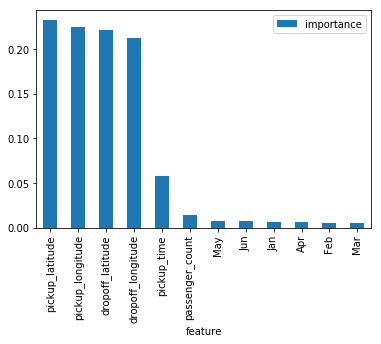

In [21]:
importances.plot.bar()

##### Here, we can see that there is a big difference in the importance of the various predictors. While pickup location and dropoff location both had importance above 0.2, pickup time was a big step down to 0.05 and the rest of the predictors (passenger count and pick month) were below 0.02/0.01. So now we know that the location of an NYC taxi is the most important factor in determining the length of time the ride will take. This does make sense intuitively, since NYC has many boroughs and each borough has its own neighborhoods, all with different "city life" and amount of traffic. Pickup time also had a little bit of importance with Random Forest, which matches the intuition of traffic hours causing different length rides.

##### If we were to do further research with this dataset, it would be interesting to see if we could determine the location/borough of rides with their longitude and latitude coordinates, and try to predict length of taxi ride based on the different borough. Just by guessing, we would think that the more lively boroughs such as Manhattan or Brooklyn would have longer taxi rides due to traffic. However, one could also spin it the other way and say that those boroughs would have shorter taxi rides since people are just trying to go a short distance but they're more difficult to just walk around in. It would also be interesting to try and find Uber or Lyft data on top of the taxi data, since using rideshares are much more common these days.

# Contributions

##### Nicholas Martz: Optimization, Linear Regression Models, Random Forest
##### Guillermo Rios Martinez: Intro & Background, Polynomial Regression, Ethics/Privacy
##### Angela Zhang: Decision Tree, Results/Conclusion/Discussion
##### Kyle Sung: Data Features & Data Cleaning